<a href="https://colab.research.google.com/github/CodeHunterOfficial/NLP_Spacy_Python/blob/main/Lecture_3_%D0%90%D1%80%D0%B8%D1%84%D0%BC%D0%B5%D1%82%D0%B8%D0%BA%D0%B0_%D1%81%D0%BB%D0%BE%D0%B2_%D0%B2%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D1%8B_TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 3.  Арифметика слов: векторы TF-IDF 

## План:
*  Подсчет слов и частотностей термов для анализа смысла. 
*  Предсказание вероятностей вхождений слов с помощью закона Ципфа. 
*  Векторные представления слов и способы их использования. 
*  Поиск релевантных документов из корпуса на основе обратных частотностей документов. 
*  Оценка сходства пар документов с помощью коэффициентов Отиаи и метрики Okapi BM25.


В данной лекции мы рассмотрим три набирающих популярность способа представления слов и их значения. 
*  Мультимножества слов — векторы количеств, или частотностей, слов. 
*  Мультимножества n-грамм — векторы количеств пар слов (биграмм), троек слов (триграмм) и т. д. 
* Векторы TF-IDF — показатели слов, наилучшим образом отражающие степень их важности.


## Метод TF-IDF 
TF-­IDF – это частотный метод, учитывающий частоту, с которой слово появляется в корпусе. Он представляет важность конкретного слова в данном документе. Интуитивно понятно, что чем выше частота слова, тем важнее это слово в документе. Например, в документе о кошках слово «кошка» будет встречаться довольно часто. Однако простое вычисление частоты не сработает, потому что такие слова, как «этот», «который», встречаются очень часто, но не содержат столько информации. TF­IDF учитывает это и присваивает нулевой вес подобным распространенным словам. 

TF означает частоту термина (term frequency), а IDF – обратную частоту документа (inverse document frequency):


 

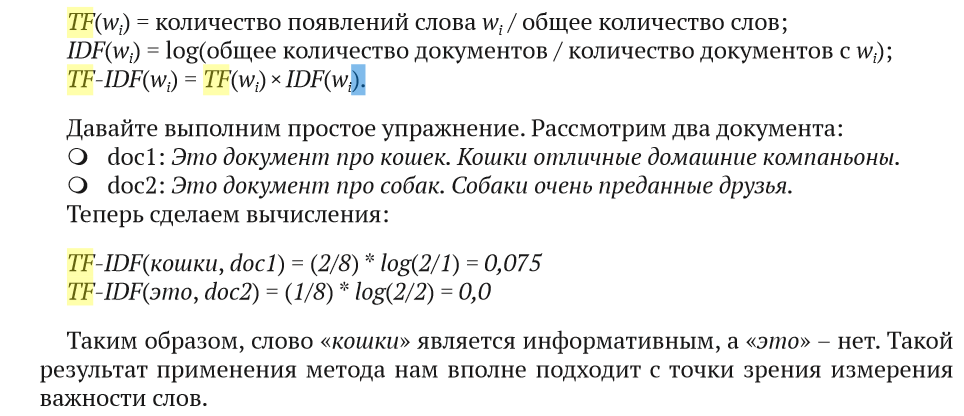

### Мультимножество слов

В предыдущей главе мы создали вашу первую модель векторного пространства текста. Для этого мы создали унитарные представления всех слов, а затем объединили все эти векторы с помощью бинарного OR (или усеченной версии sum) в векторное представление всего текста. Получившийся в результате бинарный вектор мультимножества слов, будучи загруженным в структуру данных вроде DataFrame библиотеки Pandas, оказывается отличным индексом для поиска документов.

Далее мы рассмотрели еще более удобное векторное представление с подсчетом количества вхождений (частотности) слова в тексте. На первый взгляд, чем чаще встречается слово в тексте, тем больший вклад вносит в его смысл. Документ, в котором часто упоминаются «крылья» и «руль», с большей вероятностью связан с самолетами или воздушными путешествиями, чем документ со словами «кошки» и «гравитация». Если некоторые слова были классифицированы как отражающие положительные эмоции — вроде good, best, joy и fantastic, то тональность содержащего их документа, скорее всего, положительная. Впрочем, понятно, что основанный на таких простых правилах алгоритм может легко ошибиться. 

Рассмотрим пример, в котором подсчет частотностей слов оказывается полезным: 

In [ ]:
 from nltk.tokenize import TreebankWordTokenizer 
 sentence = """The faster Harry got to the store, the faster Harry, the faster, would get home.""" 
 tokenizer = TreebankWordTokenizer()
 tokens = tokenizer.tokenize(sentence.lower())
 tokens 

['the',
 'faster',
 'harry',
 'got',
 'to',
 'the',
 'store',
 ',',
 'the',
 'faster',
 'harry',
 ',',
 'the',
 'faster',
 ',',
 'would',
 'get',
 'home',
 '.']

Этот простой список нужен, чтобы выделить из документа уникальные слова и найти их количества. Словарь Python отлично подходит для этой цели. Поскольку необходимо хранить еще и количества вхождений слов, можно воспользоваться типом Counter, как мы делали в предыдущих главах: 

In [ ]:
from collections import Counter
bag_of_words = Counter(tokens)
bag_of_words

Counter({'the': 4,
         'faster': 3,
         'harry': 2,
         'got': 1,
         'to': 1,
         'store': 1,
         ',': 3,
         'would': 1,
         'get': 1,
         'home': 1,
         '.': 1})

Как и в любом хорошем словаре Python, порядок ключей перемешивается. Новый порядок оптимизирован для хранения, обновления и поиска, а не для согласованного отображения. Информация, заключенная в порядке слов исходного высказывания, отбрасывается.


## ПРИМЕЧАНИЕ.

Объект collections.Counter — неупорядоченная коллекция, также называемая мультимножеством. В зависимости от платформы и версии Python счетчик может отображаться в, казалось бы, логичном порядке, например в лексикографическом или в порядке токенов в высказывании. Но рассчитывать на какой-либо определенный порядок токенов (ключей) как в объекте Counter, так и в обычном классе dict языка Python нельзя.


Для коротких документов, как этот, даже в неупорядоченном мультимножестве слов содержится немало информации об исходном подтексте предложения. Причем информации в мультимножестве достаточно для весьма серьезных задач, таких как обнаружение спама, анализ тональности (позитивность, счастье и т. д.), и даже для выявления таких тонких эмоций, как сарказм. Да, это просто набор слов, но наполненный смыслом и информацией. Итак, проранжируем эти слова — отсортируем их в более удобном для понимания порядке. У объекта Counter есть весьма удобный метод most_common, предназначенный именно для этой цели:

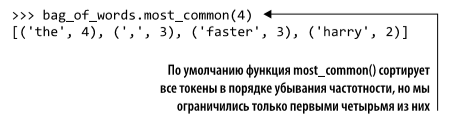

In [ ]:
bag_of_words.most_common(4)

[('the', 4), ('faster', 3), (',', 3), ('harry', 2)]

Количество вхождений слова в заданном документе называется частотностью терма (term frequency, TF). Иногда можно встретить нормализованные путем деления на общее число термов в документе количества слов.

Итак, наши четыре чаще всего встречающихся терма (токена): the, «,», harry и faster. Впрочем, the и запятая не несут много информации об основной мысли этого документа. Скорее всего, эти неинформативные токены будут встречаться вам еще много раз. Поэтому в данном случае их лучше игнорировать, как и целый список стандартных английских стоп-слов и знаков препинания. Конечно, это не всегда имеет смысл делать, но такое решение позволит пока упростить наш пример. Это сокращает список самых употребляемых токенов в векторе TF (мультимножестве слов) до harry и faster.

Подсчитаем частотность терма harry из описанного выше объекта Counter (bag_of_words):


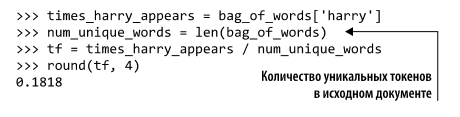

In [ ]:
times_harry_appears=bag_of_words['harry']
num_unique_words=len(bag_of_words)
tf=times_harry_appears/num_unique_words
round(tf, 4)

0.1818

Притормозим и обратим внимание на нормализованную частоту термов — фразу (и сопутствующие ей вычисления), которая встречается на протяжении всего курса. Под этим термином понимается количество слов относительно длины документа. Зачем вообще делить на длину документа? Представим, что dog встречается три раза в документе А и 100 раз в документе B. Это слово явно играет куда более важную роль во втором случае. Но если документ А — письмо ветеринару из 30 слов, а B — «Война и мир» Л. Н. Толстого (приблизительно 580 тыс. слов!)? Тогда наши изначальные выводы меняются на диаметрально противоположные. Следующие уравнения учитывают длину документа: 

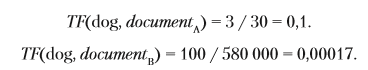

Теперь у вас есть что-то, что позволяет понять разницу между двумя документами, их связь с dog и друг с другом. Таким образом, вместо чистых количеств слов можно использовать для описания документов из корпуса нормализованные частотности термов. Аналогичным образом можно вычислить этот показатель для каждого из слов и узнать относительную важность данного терма для каждого документа. Наш главный герой, Гарри, и его жажда скорости, несомненно, являются центром описанной истории. Мы добились значительных успехов в превращении текста в числа, намного выходящих за пределы фиксации наличия/отсутствия заданного слова в тексте. Очевидно, что это довольно «притянутый за уши» пример, но скоро мы увидим, насколько значимые результаты могут быть получены при таком подходе. Рассмотрим больший фрагмент текста. Возьмем несколько первых абзацев из статьи «Википедии» о воздушных змеях (kites):

A kite is traditionally a tethered heavier-than-air craft with wing surfaces that react against the air to create lift and drag. A kite consists of wings, tethers, and anchors. Kites often have a bridle to guide the face of the kite at the correct angle so the wind can lift it. A kite’s wing also may be so designed so a bridle is not needed; when kiting a sailplane for launch, the tether meets the wing at a single point. A kite may have fixed or moving anchors. Untraditionally in technical kiting, a kite consists of tether-set-coupled wing sets; even in technical kiting, though, a wing in the system is still often called the kite. 

The lift that sustains the kite in flight is generated when air flows around the kite’s surface, producing low pressure above and high pressure below the wings. The interaction with the wind also generates horizontal drag along the direction of the wind. The resultant force vector from the lift and drag force components is opposed by the tension of one or more of the lines or tethers to which the kite is attached. The anchor point of the kite line may be static or moving (such as the towing of a kite by a running person, boat, free-falling anchors as in paragliders and fugitive parakites or vehicle). 

The same principles of fluid flow apply in liquids and kites are also used under water. 

A hybrid tethered craft comprising both a lighter-than-air balloon as well as a kite lifting surface is called a kytoon. 

Kites have a long and varied history and many different types are flown individually and at festivals worldwide. Kites may be flown for recreation, art or other practical uses. Sport kites can be flown in aerial ballet, sometimes as part of a competition. Power kites are multi-line steerable kites designed to generate large forces which can be used to power activities such as kite surfing, kite landboarding, kite fishing, kite buggying and a new trend snow kiting. Even Man-lifting kites have been made.

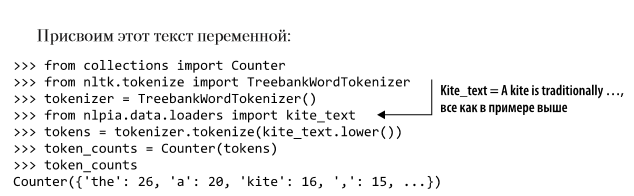

In [2]:
kite_text='A kite is traditionally a tethered heavier-than-air craft with wing surfaces that react\nagainst the air to create lift and drag. A kite consists of wings, tethers, and anchors. Kites\noften have a bridle to guide the face of the kite at the correct angle so the wind can lift it.\nA kite’s wing also may be so designed so a bridle is not needed; when kiting a sailplane\nfor launch, the tether meets the wing at a single point. A kite may have fixed or moving\nanchors. Untraditionally in technical kiting, a kite consists of tether-set-coupled wing\nsets; even in technical kiting, though, a wing in the system is still often called the kite.\nThe lift that sustains the kite in flight is generated when air flows around the kite’s\nsurface, producing low pressure above and high pressure below the wings. The\ninteraction with the wind also generates horizontal drag along the direction of the wind.\nThe resultant force vector from the lift and drag force components is opposed by the\ntension of one or more of the lines or tethers to which the kite is attached. The anchor\npoint of the kite line may be static or moving (such as the towing of a kite by a running\nperson, boat, free-falling anchors as in paragliders and fugitive parakites or vehicle).\nThe same principles of fluid flow apply in liquids and kites are also used under water.\nA hybrid tethered craft comprising both a lighter-than-air balloon as well as a kite lifting\nsurface is called a kytoon.\nKites have a long and varied history and many different types are flown individually and\nat festivals worldwide. Kites may be flown for recreation, art or other practical uses.\nSport kites can be flown in aerial ballet, sometimes as part of a competition. Power kites\nare multi-line steerable kites designed to generate large forces which can be used to\npower activities such as kite surfing, kite landboarding, kite fishing, kite buggying and a\nnew trend snow kiting. Even Man-lifting kites have been made.'

In [3]:
from collections import Counter
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()
#from nlpia.data.loaders import kite_text
tokens = tokenizer.tokenize(kite_text.lower())
token_counts = Counter(tokens)
print(token_counts)

Counter({'the': 26, 'a': 20, 'kite': 14, ',': 14, 'and': 10, 'of': 10, 'kites': 8, 'is': 7, 'in': 7, 'or': 6, 'as': 6, 'wing': 5, 'to': 5, 'be': 5, 'lift': 4, 'have': 4, 'may': 4, 'at': 3, 'so': 3, 'can': 3, 'also': 3, 'kiting': 3, 'are': 3, 'flown': 3, 'tethered': 2, 'craft': 2, 'with': 2, 'that': 2, 'air': 2, 'consists': 2, 'tethers': 2, 'anchors.': 2, 'often': 2, 'bridle': 2, 'wind': 2, 'kite’s': 2, 'designed': 2, ';': 2, 'when': 2, 'for': 2, 'moving': 2, 'technical': 2, 'even': 2, 'called': 2, 'surface': 2, 'pressure': 2, 'drag': 2, 'force': 2, 'by': 2, 'which': 2, 'such': 2, '.': 2, 'used': 2, 'power': 2, 'traditionally': 1, 'heavier-than-air': 1, 'surfaces': 1, 'react': 1, 'against': 1, 'create': 1, 'drag.': 1, 'wings': 1, 'guide': 1, 'face': 1, 'correct': 1, 'angle': 1, 'it.': 1, 'not': 1, 'needed': 1, 'sailplane': 1, 'launch': 1, 'tether': 1, 'meets': 1, 'single': 1, 'point.': 1, 'fixed': 1, 'untraditionally': 1, 'tether-set-coupled': 1, 'sets': 1, 'though': 1, 'system': 1, 'st

### ПРИМЕЧАНИЕ.

TreebankWordTokenizer возвращает kite. (с точкой) в качестве токена. Treebank Tokenizer предполагает, что документ уже был сегментирован на отдельные предложения, поэтому он игнорирует пунктуацию только в конце строки. Сегментация предложений — очень сложный вопрос, и мы будем обсуждать ее только в главе 11. Тем не менее синтаксический анализатор spaCy работает быстрее и точнее, чем Treebank, ввиду того, что он выполняет сегментацию и токенизацию предложений (наряду со многими другими действиями)1 за один проход. Так что лучше применять для реальных приложений spaCy, а не использовавшиеся для простых примеров выше компоненты NLTK.

Ладно, вернемся к примеру. Вы уже заметили огромное количество стоп-слов? Наверняка эта статья из «Википедии» не об артиклях the, a, союзе and и т. д. Их пока отбросим: 

In [4]:
import nltk
nltk.download('stopwords', quiet=True)

True

In [5]:
stopwords = nltk.corpus.stopwords.words('english')
tokens = [x for x in tokens if x not in stopwords]
kite_counts = Counter(tokens)
kite_counts

Counter({'kite': 14,
         'traditionally': 1,
         'tethered': 2,
         'heavier-than-air': 1,
         'craft': 2,
         'wing': 5,
         'surfaces': 1,
         'react': 1,
         'air': 2,
         'create': 1,
         'lift': 4,
         'drag.': 1,
         'consists': 2,
         'wings': 1,
         ',': 14,
         'tethers': 2,
         'anchors.': 2,
         'kites': 8,
         'often': 2,
         'bridle': 2,
         'guide': 1,
         'face': 1,
         'correct': 1,
         'angle': 1,
         'wind': 2,
         'it.': 1,
         'kite’s': 2,
         'also': 3,
         'may': 4,
         'designed': 2,
         'needed': 1,
         ';': 2,
         'kiting': 3,
         'sailplane': 1,
         'launch': 1,
         'tether': 1,
         'meets': 1,
         'single': 1,
         'point.': 1,
         'fixed': 1,
         'moving': 2,
         'untraditionally': 1,
         'technical': 2,
         'tether-set-coupled': 1,
         'sets'

Определенные выводы о содержании документа можно сделать, исходя даже из одной информации о частотностях слов в нем. Слова kite(s), wing и lift обладают большой важностью. Даже если вы не имеете понятия о содержании этого документа и просто наткнулись на него в своей обширной базе данных (масштабов Google), то смогли бы «программным образом» сделать вывод, что он как-то связан с полетами или подъемами в воздух или же с воздушными змеями. 

Если рассматривать несколько документов в корпусе, то все становится немного интереснее. Набор документов может, например, быть целиком посвящен воздушным змеям. Логично предположить, что во всех документах из него упоминается веревка (string) и ветер (wind), а частотность термов TF("string") и TF("wind") будет высокой во всех документах. Теперь рассмотрим способ более изящного представления этих чисел в математических целях. 

# Векторизация 

Мы уже сталкивались с простейшими преобразованиями текста в числа. Но мы просто сохранили числа в словаре, сделав первый шаг из мира текста в мир математики. Теперь мы отправимся дальше по этому пути. Вместо описания документа в терминах частотного словаря мы сформируем из этих количеств слов вектор. В Python он будет представлять собой список, но в общем случае он может быть упорядоченной коллекцией или массивом. Это можно проделать быстро с помощью следующего кода: 

In [6]:
document_vector = []
doc_length = len(tokens)
for key, value in kite_counts.most_common():
  document_vector.append(value / doc_length)
document_vector 

[0.06422018348623854,
 0.06422018348623854,
 0.03669724770642202,
 0.022935779816513763,
 0.01834862385321101,
 0.01834862385321101,
 0.013761467889908258,
 0.013761467889908258,
 0.013761467889908258,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.009174311926605505,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0045871559633027525,
 0.00

Над этим списком (вектором) можно уже непосредственно производить математические операции.

## ПРИМЕЧАНИЕ.
Существует много способов ускорить обработку подобных структур данных.

Применять математику лишь к одному элементу не очень интересно. Одного вектора для одного документа недостаточно. Лучше взять еще парочку документов и создать для них векторы. Но содержащиеся во всех векторах значения должны относиться к общей точке отсчета. Для проведения с ними вычислений они должны отражать точку в пространстве относительно единого начала координат. Вектору нужны общая точка отсчета и одинаковые масштабы («единицы измерения») в каждом из их измерений. Первый этап данного процесса — нормализация количеств слов путем подсчета нормализованных частотностей термов вместо простых количеств вхождений слов в документе (как мы делали в предыдущем разделе). Второй — приведение всех векторов к единой длине (размеру). 

Кроме того, значение каждого элемента вектора должно отражать одно и то же слово в векторах для всех документов. Но наше письмо ветеринару вряд ли будет включать столько же слов, как «Война и мир» (а может, и будет, кто знает?). Не переживайте, если некоторые из векторов будут содержать нулевые значения на некоторых позициях. Находим все уникальные слова в каждом из наших двух документов, а затем — все уникальные слова в объединении этих двух множеств. Такие наборы слов часто называются лексиконом, что отражает уже встречавшееся нам в предыдущих главах понятие, только в терминах конкретного корпуса. Посмотрим, как это работает с документами немного меньшего размера, нежели «Война и мир». Вернемся к нашему Гарри. У вас уже есть один «документ» о нем, увеличим наш корпус еще на парочку: 

In [8]:
docs = ["The faster Harry got to the store, the faster and faster Harry would get home."]
docs.append("Harry is hairy and faster than Jill.")
docs.append("Jill is not as hairy as Harry.")
docs

['The faster Harry got to the store, the faster and faster Harry would get home.',
 'Harry is hairy and faster than Jill.',
 'Jill is not as hairy as Harry.']

### ПРИМЕЧАНИЕ.
Для удобства, чтобы не набирать эти тексты вручную, вы можете импортировать их из пакета nlpia: from nlpia.data.loaders import harry_docs as docs.

In [10]:
!pip install nlpia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.0 MB 2.4 MB/s 
     |████████████████████████████████| 706 kB 53.5 MB/s 
     |████████████████████████████████| 120 kB 60.6 MB/s 
     |████████████████████████████████| 1.6 MB 50.8 MB/s 
     |████████████████████████████████| 210 kB 61.9 MB/s 
     |████████████████████████████████| 170 kB 61.9 MB/s 
     |████████████████████████████████| 2.2 MB 48.1 MB/s 
     |████████████████████████████████| 82 kB 661 kB/s 


In [11]:
from nlpia.data.loaders import harry_docs as docs
docs

/usr/local/lib/python3.7/dist-packages/pugnlp/constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
/usr/local/lib/python3.7/dist-packages/pugnlp/constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
/usr/local/lib/python3.7/dist-packages/pugnlp/tutil.py:100: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
/usr/local/lib/python3.7/dist-packages/pugnlp/util.py:80: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
/usr/local/lib/python3.7/dist-packages/nlpia

['The faster Harry got to the store, the faster and faster Harry would get home.',
 'Harry is hairy and faster than Jill.',
 'Jill is not as hairy as Harry.']


Взглянем на наш лексикон для корпуса из трех документов: 

In [12]:
doc_tokens = []
for doc in docs:
  doc_tokens += [sorted(tokenizer.tokenize(doc.lower()))]
len(doc_tokens[0]) 

17

In [16]:
doc_tokens

[[',',
  '.',
  'and',
  'faster',
  'faster',
  'faster',
  'get',
  'got',
  'harry',
  'harry',
  'home',
  'store',
  'the',
  'the',
  'the',
  'to',
  'would'],
 ['.', 'and', 'faster', 'hairy', 'harry', 'is', 'jill', 'than'],
 ['.', 'as', 'as', 'hairy', 'harry', 'is', 'jill', 'not']]

In [13]:
all_doc_tokens = sum(doc_tokens, [])
len(all_doc_tokens) 

33

In [15]:
all_doc_tokens

[',',
 '.',
 'and',
 'faster',
 'faster',
 'faster',
 'get',
 'got',
 'harry',
 'harry',
 'home',
 'store',
 'the',
 'the',
 'the',
 'to',
 'would',
 '.',
 'and',
 'faster',
 'hairy',
 'harry',
 'is',
 'jill',
 'than',
 '.',
 'as',
 'as',
 'hairy',
 'harry',
 'is',
 'jill',
 'not']

In [14]:
lexicon = sorted(set(all_doc_tokens))
len(lexicon)

18

In [18]:
lexicon

[',',
 '.',
 'and',
 'as',
 'faster',
 'get',
 'got',
 'hairy',
 'harry',
 'home',
 'is',
 'jill',
 'not',
 'store',
 'than',
 'the',
 'to',
 'would']

Каждый из трех векторов документов должен содержать 18 значений, даже если в соответствующем документе содержатся не все 18 слов из лексикона. Каждому токену выделяется место в векторах в соответствии с его позицией в лексиконе. Некоторые из этих количеств токенов будут равны нулю, что нам, собственно, и нужно: 

In [19]:
from collections import OrderedDict
zero_vector = OrderedDict((token, 0) for token in lexicon)
zero_vector

OrderedDict([(',', 0),
             ('.', 0),
             ('and', 0),
             ('as', 0),
             ('faster', 0),
             ('get', 0),
             ('got', 0),
             ('hairy', 0),
             ('harry', 0),
             ('home', 0),
             ('is', 0),
             ('jill', 0),
             ('not', 0),
             ('store', 0),
             ('than', 0),
             ('the', 0),
             ('to', 0),
             ('would', 0)])

Далее мы копируем базовый вектор, обновляем его значения для каждого документа и сохраняем в массиве:

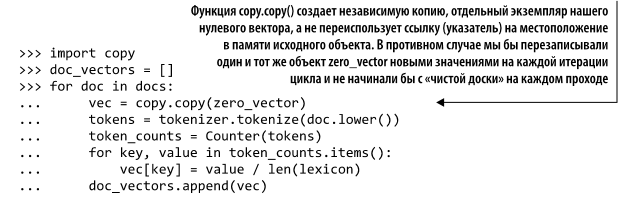

In [20]:
import copy
doc_vectors = []
for doc in docs:
    vec = copy.copy(zero_vector)
    tokens = tokenizer.tokenize(doc.lower())
    token_counts = Counter(tokens)
    for key, value in token_counts.items():
        vec[key] = round(value / len(lexicon), 4)
    doc_vectors.append(vec)

for i, doc_vec in enumerate(doc_vectors):
    print("{} : {}".format(i + 1, doc_vec), '\n')

1 : OrderedDict([(',', 0.0556), ('.', 0.0556), ('and', 0.0556), ('as', 0), ('faster', 0.1667), ('get', 0.0556), ('got', 0.0556), ('hairy', 0), ('harry', 0.1111), ('home', 0.0556), ('is', 0), ('jill', 0), ('not', 0), ('store', 0.0556), ('than', 0), ('the', 0.1667), ('to', 0.0556), ('would', 0.0556)]) 

2 : OrderedDict([(',', 0), ('.', 0.0556), ('and', 0.0556), ('as', 0), ('faster', 0.0556), ('get', 0), ('got', 0), ('hairy', 0.0556), ('harry', 0.0556), ('home', 0), ('is', 0.0556), ('jill', 0.0556), ('not', 0), ('store', 0), ('than', 0.0556), ('the', 0), ('to', 0), ('would', 0)]) 

3 : OrderedDict([(',', 0), ('.', 0.0556), ('and', 0), ('as', 0.1111), ('faster', 0), ('get', 0), ('got', 0), ('hairy', 0.0556), ('harry', 0.0556), ('home', 0), ('is', 0.0556), ('jill', 0.0556), ('not', 0.0556), ('store', 0), ('than', 0), ('the', 0), ('to', 0), ('would', 0)]) 



Итак, у нас есть три вектора. По одному на каждый документ. «И что дальше? Что мы можем с ними сделать?» — спросите вы. С векторами, содержащими количества слов, можно делать множество интересных вещей, как и с любыми другими, так что сначала узнаем больше о векторах и векторных пространствах1

# Векторные пространства

### Линейные пространства: определение и примеры

http://mathhelpplanet.com/static.php?p=linyeinye-prostranstva




Векторы — краеугольный камень линейной алгебры (векторной алгебры). По своей сути это упорядоченные последовательности чисел (координат) в векторном пространстве. Они описывают место (положение) в данном пространстве. Могут использоваться и для задания конкретного направления и модуля (расстояния) в этом пространстве. Пространство — это совокупность всех возможных векторов, которые могут в нем встречаться. Таким образом, вектор с двумя значениями будет располагаться в двумерном векторном пространстве, вектор с тремя значениями в трехмерном векторном пространстве и т. д. 

Кусок миллиметровки или сетка пикселов на изображении — это допустимые двумерные векторные пространства. Нетрудно заметить, как важен порядок этих координат. Если поменять местами координаты x и y для местоположений на миллиметровке без соответствующей корректировки операций над векторами, то все решения задач линейной алгебры окажутся зеркально отраженными. Миллиметровка и сетка пикселов изображения — примеры евклидовых пространств, потому что оси координат x и y перпендикулярны друг другу. Обсуждаемые в этой главе векторные пространства являются евклидовыми пространствами

А как насчет широты и долготы на карте или глобусе? Карта и глобус — определенно двумерные векторные пространства, ввиду того что представляют собой упорядоченный список двух чисел: широты и долготы. Каждая из пар широта — долгота описывает точку на приближенно сферической бугристой поверхности Земли. Вдобавок угол между осями координат широты и долготы не равен в точности 90°, поэтому векторное пространство широты и долготы не является линейным. Это означает, что вы должны быть осторожны, когда вычисляете такие вещи, как расстояние/близость (сходство) между двумя точками, представленными парой 2D-векторов широты и долготы или векторов в любом неевклидовом пространстве. Представьте, например, вычисление расстояния между координатами широты и долготы Портленда, штат Орегон, и Нью-Йорка, штат Нью-Йорк.

На рис. 3.1 показан один из способов изображения 2D-векторов с координатами (5, 5), (3, 2) и (–1, 1). «Вершина» вектора (острый конец стрелки) указывает на местоположение в векторном пространстве. Поэтому вершины векторов на этом графике находятся в точках, соответствующих указанным трем парам координат. Хвост вектора («задняя» часть стрелки) всегда в начале координат (0, 0). 

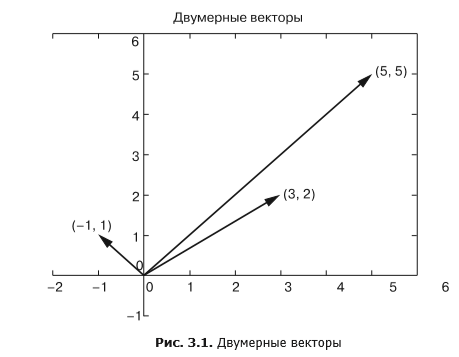

А как насчет трехмерных векторных пространств? Положения и скорости в трехмерном физическом мире, в котором мы с вами живем, можно отразить с помощью координат x, y и z трехмерного вектора. Или рассмотреть криволинейное пространство из троек «широта — долгота — высота», описывающих местоположения объектов вблизи поверхности Земли.

К счастью, мы не ограничены обычным 3D-пространством. Наше пространство может быть 5-, 10- или 5000-мерным! Линейная алгебра во всех случаях работает одинаково. Но по мере роста размерности пространства могут потребоваться большие вычислительные мощности. Возможны также определенные проблемы проклятия размерности, но этот вопрос мы пока отложим.

Для векторного пространства документов на естественном языке размерность векторного пространства равна числу различных слов во всем корпусе. Для TF (и далее и TF-IDF) мы иногда будем использовать для обозначения этой размерности прописную букву K. Это число отдельных слов также является размером словаря корпуса, поэтому в теоретических статьях его обычно обозначают |V|. Любой документ в K-мерном векторном пространстве можно описать с помощью K-мерного вектора. В случае нашего корпуса из трех документов о Гарри и Джилл K = 18. Поскольку наглядно представить себе пространство размерности больше трех непросто, проигнорируем большую их часть и рассмотрим пока что только два, чтобы изобразить его векторы на лежащей перед вами плоской странице. На рис. 3.2 K уменьшено до двух для 2D-представления 18-мерного векторного пространства Гарри и Джилл. 

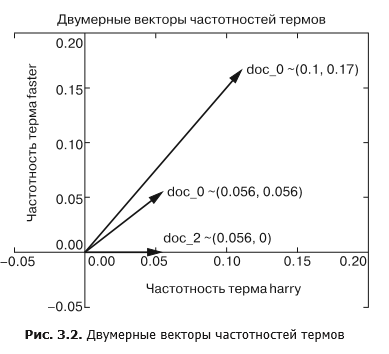

К-мерные векторы аналогичны данным, просто это сложно представить наглядно. Теперь у нас есть векторные представления всех документов в одном пространстве, а значит, появилась возможность их сравнить. Измерить евклидово расстояние между векторами можно путем их вычитания и вычисления длины расстояния между ними, называемого расстоянием в смысле L2-нормы (метрики L2). Это расстояние по прямой от места, задаваемого острием (вершиной) одного вектора, до местоположения, соответствующего острию другого вектора. В приложении C, посвященном линейной алгебре, рассказывается, почему этот метод не подходит для векторов количества слов (частотностей термов). 

## Евклидова метрика
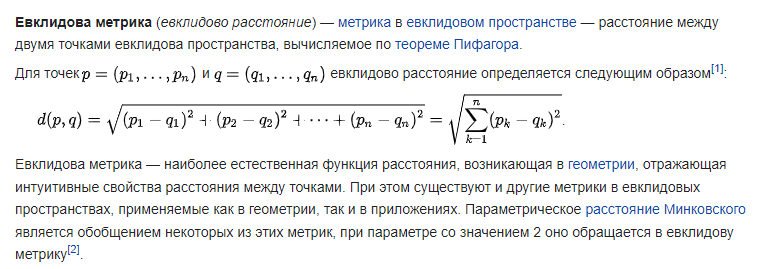

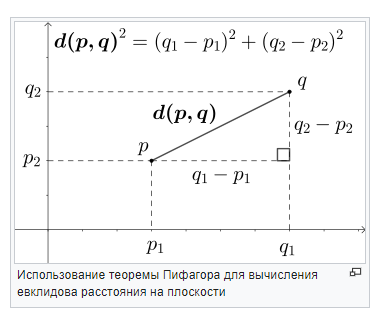

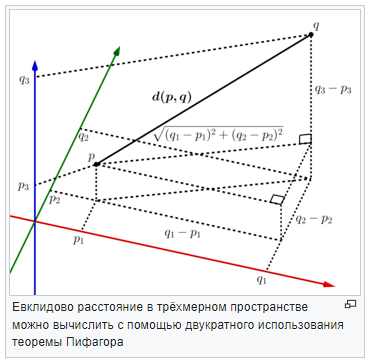

## Норма — функционал, заданный на векторном пространстве и обобщающий понятие длины вектора или абсолютного значения числа.

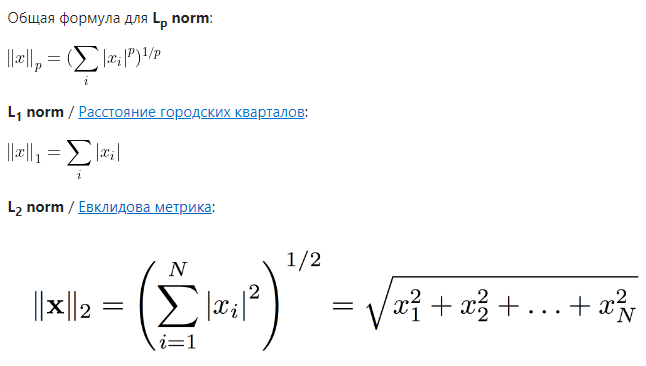

Два вектора считаются подобными, если они имеют одинаковое направление. Их модули (длины) также могут быть равны, означая, что векторы количеств слов (частотностей термов) относятся к документам примерно одинаковой длины. Но важна ли длина документов при оценке подобия векторных представлений слов в документах? Скорее всего, нет.

Желательно, чтобы наша оценка уровня подобия документов учитывала одни и те же слова аналогичное число раз в одинаковых пропорциях. Благодаря столь точным оценкам можно быть уверенными, что отражаемые ими документы, вероятно, посвящены близким вещам. 

Коэффициент Отиаи (коэффициент косинусного подобия) представляет собой просто косинус угла между двумя векторами (theta), показанными на рис. 3.3. Его можно вычислить с помощью евклидова скалярного произведения по формуле: 


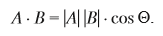

Коэффициент Отиаи удобно вычислять, поскольку скалярное произведение не требует вычисления каких-либо тригонометрических функций. Кроме того, диапазон принимаемых коэффициентом Отиаи значений удобен для большинства задач машинного обучения: от –1 до +1.

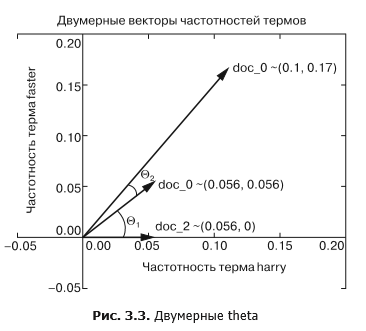

На языке Python эта формула выглядит следующим образом:
## a.dot(b)=np.linalg.norm(a)*np.linalg.norm(b)/np.cos(theta)

 Решая это уравнение относительно cos(theta), получаем коэффициент Отиаи:

 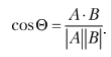


Можно сделать это на чистом Python, не используя пакет numpy, как в листинге 3.1.

In [41]:
import math
def cosine_sim(vec1, vec2): 
  #Let's convert our dictionaries to lists for easier matching.
  vec1 = [val for val in vec1.values()]
  vec2 = [val for val in vec2.values()]
  dot_prod = 0
  for i, v in enumerate(vec1):
    dot_prod += v * vec2[i]
  mag_1 = math.sqrt(sum([x**2 for x in vec1]))
  mag_2 = math.sqrt(sum([x**2 for x in vec2]))
  return dot_prod / (mag_1 * mag_2)

In [42]:
#doc_vectors[2]
print(cosine_sim(doc_vectors[0], doc_vectors[1]))
print(cosine_sim(doc_vectors[0], doc_vectors[2]))
print(cosine_sim(doc_vectors[1], doc_vectors[2]))

0.44447830760273627
0.1704267528351682
0.5592180976753798


Итак, нужно вычислить скалярное произведение двух векторов — умножить элементы векторов попарно, а затем просуммировать полученные результаты. После этого поделить результат на норму (модуль, то есть длину) каждого вектора. Норма вектора равна евклидову расстоянию от его головы до хвоста — квадратному корню суммы квадратов его элементов. Это нормализованное скалярное произведение, как и значение косинуса, располагается между –1 и 1. Оно также является косинусом угла между этими двумя векторами. Данное значение равно доле более длинного вектора, охваченной перпендикулярной проекцией на него более короткого вектора. Из этого ясно, насколько наши два вектора направлены в одну сторону. 

Равный 1 косинусный коэффициент отражает одинаковые нормализованные векторы, указывающие в аналогичном направлении по всем измерениям. Длины (модули) этих векторов могут быть различными, но они указывают в одном и том же направлении. Помните, что мы поделили скалярное произведение на норму каждого вектора, причем это можно делать до или после вычисления скалярного произведения. Таким образом, при его вычислении векторы нормализованы, длины обоих равны 1. Мы можем сделать вывод: чем ближе значение косинусного сходства к 1, тем меньше угол между векторами. В NLP документы, косинусный коэффициент векторов которых близок к 1, содержат похожие слова в одинаковой пропорции. Таким образом, документы, векторы которых близки друг к другу, скорее всего, посвящены одному и тому же.

При косинусном коэффициенте, равном 0, векторы не имеют общих компонентов. Они находятся под углом 90° относительно друг друга по всем измерениям. Для векторов TF NLP такая ситуация возникает только в случае, если в двух документах нет общих слов. Поскольку в них используются совершенно разные слова, они обсуждают абсолютно разные вещи. Это не обязательно означает различный их смысл или тематику, просто в них применяются разные слова. 

При значении косинусного коэффициента, равном –1, векторы полностью противоположные. Они указывают в противоположных направлениях. Такого не может произойти ни с простыми векторами количеств слов (частотностей термов), ни даже с нормализованными TF-векторами (которые мы обсудим далее). Векторы количеств слов (частотностей термов) не могут быть отрицательными. Таким образом, последние всегда будут находиться в одном квадранте векторного пространства. Ни один из векторов частотностей термов не может «пробраться» в какой-либо из квадрантов, расположенных «за спиной» других векторов. Ни один компонент какого-либо из TF-векторов не может быть противоположным какомулибо компоненту другого вектора ввиду того, что частотность слова просто не может быть отрицательной.

 В этой лекции вы не увидите никаких отрицательных значений косинусного сходства. Однако в следующей мы разработаем концепцию слов и тем, противоположных друг другу. В таком случае вы увидите документы, слова и темы, значение косинусного сходства которых меньше 0 или даже равно –1.


ПРОТИВОПОЛОЖНОСТИ ПРИТЯГИВАЮТСЯ

>  Из нашего способа вычисления косинусного коэффициента следует интересное свойство. Если косинусные коэффициенты двух векторов или документов равны –1 (то есть они являются противоположностями) относительно третьего вектора, они должны быть подобны друг другу — в точности идентичны. Однако документы, которые представляют эти векторы, могут не совпадать. В них не только может быть разный порядок слов, но и один может быть намного длиннее другого, если в нем используются те же слова в той же пропорции.


Позже вы узнаете о векторах, которые намного точнее моделируют документ, а пока вы получили хорошее представление о необходимых инструментах.

## Закон Ципфа 

Приступим к нашей основной теме — социологии. Ладно, на самом деле не совсем, но вам предстоит краткий экскурс в мир подсчетов людей и слов, в ходе которого вы узнаете, вероятно, универсальное правило,обуславливающее подсчеты большинства вещей. Оказывается, что язык, как и большинство вещей, связанных с живыми организмами, изобилует закономерностями. 

В начале XX века французский стенографист Жан-Батист Эсту (Jean-Baptiste Estoup) обнаружил закономерность частотностей слов, которые он старательно подсчитывал вручную во многих документах (хвала небесам, что у нас есть компьютеры и Python). В 1930-х годах американский лингвист Джордж Кингсли Ципф попытался формализовать наблюдения Эсту, и в итоге эти закономерности стали носить имя Ципфа.


Закон Ципфа гласит, что в некотором корпусе высказываний на естественном языке частотность любого слова обратно пропорциональна его позиции в таблице частотностей. («Википедия»)


Точнее говоря, фраза «обратная пропорциональность» относится к ситуации, когда частотность элемента ранжированного списка явным образом связана с его местом в списке. Например, первый элемент ранжированного списка может встречаться в два раза чаще, чем второй, и в три раза чаще, чем третий. Для любого корпуса или документа можно быстро построить график частоты использования слов относительно их позиции в таблице частотностей. Любые аномальные значения, выделяющиеся на прямой линии графика с двойной логарифмической шкалой, заслуживают исследования. 

В качестве примера того, как далеко закон Ципфа выходит за пределы мира слов, рис. 3.4 демонстрирует взаимосвязь между населением городов США и их местом в таблице численности населения. Оказывается, что закон Ципфа применим к частотностям множества вещей. Природа полна систем, в которых наблюдаются экспоненциальный рост и такие сетевые эффекты, как динамика численности населения, рост объемов производства и распределение ресурсов1. Интересно, что нечто столь простое, как закон Ципфа, справедливо для столь широкого диапазона природных и техногенных явлений. Нобелевский лауреат Пол Кругман (Paul Krugman), говоря об экономических моделях и законе Ципфа, сформулировал это так:

«На экономические теории обычно жалуются, что наши модели излишне упрощены и их отражение сложной беспорядочной реальности слишком “приглаженное”. [Относительно закона Ципфа] верно обратное: модели сложны и беспорядочны, а реальность поразительно ясна и проста» 

На рис. 3.4 представлена обновленная версия графика Кругмана для населения городов

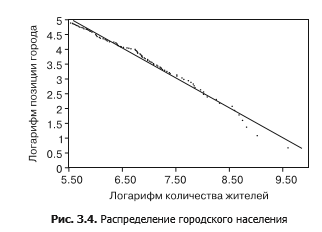

### Данные о популяции загружены из «Википедии» с помощью пакета Pandas. См. nlpia.book.examples на GitHub по адресу https://github.com/totalgood/nlpia/blob/master/src/nlpia/book/examples/ch03.py.

Для слов справедлива та же закономерность, что и для городов и социальных сетей. Для начала загрузим Brown Corpus из пакета NLTK.
Brown Corpus был первым электронным корпусом английского языка, состоящим из миллиона слов. Он был создан в 1961 году в Университете Брауна. Этот корпус содержит текст из 500 источников, классифицированных по жанрам, таким как новости, передовые статьи и т. д.[2] (Документация NLTK)

### Полный список жанров можно найти по адресу http://clu.uni.no/icame/manuals/BROWN/ INDEX.HTM#t2.


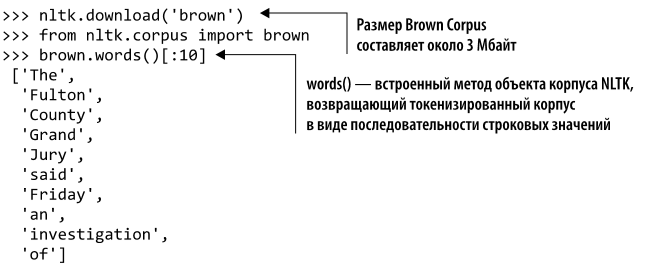

In [45]:
nltk.download('brown')
from nltk.corpus import brown
brown.words()[:10]

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


['The',
 'Fulton',
 'County',
 'Grand',
 'Jury',
 'said',
 'Friday',
 'an',
 'investigation',
 'of']

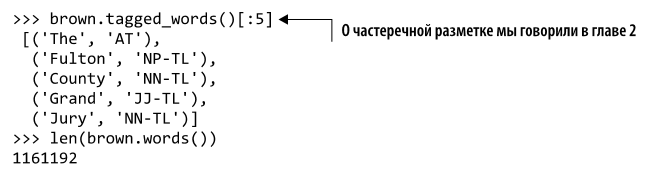

In [47]:
brown.tagged_words()[:10]

[('The', 'AT'),
 ('Fulton', 'NP-TL'),
 ('County', 'NN-TL'),
 ('Grand', 'JJ-TL'),
 ('Jury', 'NN-TL'),
 ('said', 'VBD'),
 ('Friday', 'NR'),
 ('an', 'AT'),
 ('investigation', 'NN'),
 ('of', 'IN')]

Таким образом, учитывая наличие более чем 1 миллиона токенов, у вас есть на что посмотреть: 

In [49]:
from collections import Counter
puncs = set((',', '.', '--', '-', '!', '?',':', ';', '``', "''", '(', ')', '[', ']'))
word_list = (x.lower() for x in brown.words() if x not in puncs)
token_counts = Counter(word_list)
token_counts.most_common(20) 

[('the', 69971),
 ('of', 36412),
 ('and', 28853),
 ('to', 26158),
 ('a', 23195),
 ('in', 21337),
 ('that', 10594),
 ('is', 10109),
 ('was', 9815),
 ('he', 9548),
 ('for', 9489),
 ('it', 8760),
 ('with', 7289),
 ('as', 7253),
 ('his', 6996),
 ('on', 6741),
 ('be', 6377),
 ('at', 5372),
 ('by', 5306),
 ('i', 5164)]

Сразу заметно, что частотности слов в корпусе Brown соответствуют логарифмическим отношениям, предсказанным Ципфом. The (на первом месте по частотности терма) встречается примерно в два раза чаще, чем of (на втором месте по частотности терма), и примерно в три раза чаще, чем and (на третьем месте по частотности терма). Если не верите, воспользуйтесь примером кода (https://github.com/totalgood/nlpia/blob/master/src/nlpia/book/examples/ch03_zipf.py) из пакета nlpia и убедитесь сами.

Если упорядочить слова корпуса по количеству вхождений и расположить их в порядке убывания, то при достаточно большой выборке первое слово в этом ранжированном списке встречается в корпусе в два раза чаще, чем второе. И в четыре раза чаще четвертого слова в списке. Таким образом, при достаточно большом корпусе можно на основе этого разбиения предсказать статистическую вероятность вхождения данного слова в любом из документов корпуса.

### Тематическое моделирование 

Вернемся к нашим векторам документов. Подсчет слов полезен, но чистое количество слов, даже нормализованное по длине документа, мало что говорит о важности определенного слова для смысла документа по сравнению с остальными документами корпуса. Чтобы начать описывать документы в корпусе, хорошо бы выяснить эту информацию. Допустим, что у нас есть корпус, включающий в себя все когда-либо написанные книги о воздушных змеях. Слово kite почти наверняка встречается много раз в каждой из данных книг (документов), но это не дает никакой новой информации и не помогает различить эти документы. В то время как слова вроде construction («конструкция», «конструирование») или aerodynamics («аэродинамика»), наверное, не столь распространены во всем корпусе, именно благодаря им можно узнать больше о природе тех документов, где они встречаются чаще. Для выполнения этой задачи нам понадобится еще один инструмент. 

Применить закон Ципфа при тематическом анализе нам поможет обратная частотность документа (IDF). Расширим вышеприведенный счетчик частотностей термов. Подсчитывать токены и группировать их можно двумя способами: по документам и по всему корпусу. Мы выберем первое. 

Вернемся к примеру о воздушных змеях из «Википедии», но возьмем другой отрывок (раздел History) и сделаем его вторым документом в нашем корпусе.


**Kites were invented in China, where materials ideal for kite building were readily available: silk fabric for sail material; fine, high-tensile-strength silk for flying line; and resilient bamboo for a strong, lightweight framework.**

***The kite has been claimed as the invention of the 5th-century BC Chinese philosophers Mozi (also Mo Di) and Lu Ban (also Gongshu Ban). By 549 AD paper kites were certainly being flown, as it was recorded that in that year a paper kite was used as a message for a rescue mission. Ancient and medieval Chinese sources describe kites being used for measuring distances, testing the wind, lifting men, signaling, and communication for military operations. The earliest known Chinese kites were flat (not bowed) and often rectangular. Later, tailless kites incorporated a stabilizing bowline. Kites were decorated with mythological motifs and legendary figures; some were fitted with strings and whistles to make musical sounds while flying. From China, kites were introduced to Cambodia, Thailand, India, Japan, Korea and the western world.***

 ***After its introduction into India, the kite further evolved into the fighter kite, known as the patang in India, where thousands are flown every year on festivals such as Makar Sankranti.*** 

***Kites were known throughout Polynesia, as far as New Zealand, with the assumption being that the knowledge diffused from China along with the people.***

***Anthropomorphic kites made from cloth and wood were used in religious ceremonies to send prayers to the gods. Polynesian kite traditions are used by anthropologists get an idea of early “primitive” Asian traditions that are believed to have at one time existed in Asia.  («Википедия»)*** 

Для начала посчитаем количество слов в каждом документе нашего корпуса: intro_doc и history_doc:

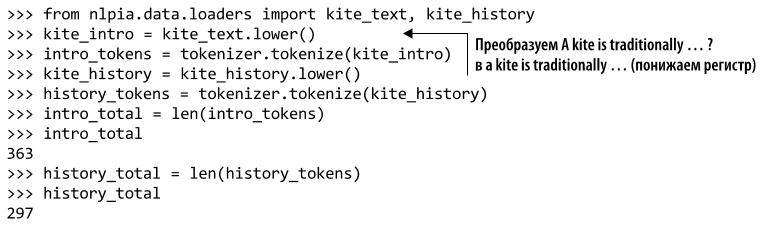

In [ ]:
#f1 = open("kite.txt","r",encoding="utf-8")
#f2 = open("kite_history.txt","r",encoding="utf-8")
#kite_text = f1.read()
#kite_history=f2.read()
#f1.close()
#f2.close()

In [50]:
from nlpia.data.loaders import kite_text, kite_history
kite_intro=kite_text.lower()
intro_tokens = tokenizer.tokenize(kite_intro)
kite_history = kite_history.lower()
history_tokens = tokenizer.tokenize(kite_history)
intro_total = len(intro_tokens)
print(intro_total)

363


In [51]:
history_total = len(history_tokens)
print(history_total)

297


Теперь найдем частотность терма kite в каждом из двух имеющихся у нас токенизированных документов о воздушных змеях. Хранить найденные TF мы будем в двух словарях, по одному для каждого документа: 

In [53]:
intro_tf = {}
history_tf = {}
intro_counts = Counter(intro_tokens)
intro_tf['kite'] = intro_counts['kite'] / intro_total
history_counts = Counter(history_tokens)
history_tf['kite'] = history_counts['kite'] / history_total
'Term Frequency of "kite" in intro is: {:.4f}'.format(intro_tf['kite']) 
#'Term Frequency of "kite" in intro is: 0.0441'

'Term Frequency of "kite" in intro is: 0.0441'

In [54]:
'Term Frequency of "kite" in history is: {:.4f}'.format(history_tf['kite']) 
#'Term Frequency of "kite" in history is: 0.0202

'Term Frequency of "kite" in history is: 0.0202'

Итак, получилось, что количество вхождений kite в первом тексте в два раза больше, чем во втором. Неужели вступительный раздел в два раза сильнее связан с воздушными змеями, чем раздел об истории их создания? Нет, не совсем. Так что копнем немного глубже. Во-первых, сопоставим эти числа с данными для какоголибо другого слова, скажем and: 

In [56]:
intro_tf['and'] = intro_counts['and'] / intro_total
history_tf['and'] = history_counts['and'] / history_total
print('Term Frequency of "and" in intro is: {:.4f}'.format(intro_tf['and']))

Term Frequency of "and" in intro is: 0.0275


In [57]:
print('Term Frequency of "and" in history is: {:.4f}'.format(history_tf['and'])) 

Term Frequency of "and" in history is: 0.0303


Ура! Теперь мы знаем, что оба эти документа посвящены and в той же мере, что и kite. Так, подождите-ка... Не очень информативно, не правда ли? Как и в первом примере про нашего быстрого друга Гарри, где система, похоже, думала, что the было самым важным словом в документе, в этом примере and считается довольно значимым. Не слишком большое достижение, даже на первый взгляд. 

Обратную частотность термов документа можно рассматривать как меру того, насколько странным является тот факт, что данный токен присутствует в конкретном документе. Если терм встречается в одном документе много раз, но редко в остальной части корпуса, можно предположить, что он играет важную роль именно в этом конкретном документе. Поздравляю, мы сделали первый шаг к тематическому моделированию! 

IDF терма — это просто отношение общего количества документов к тем, в которых встречается терм. В случае and и kite ответ одинаков для обоих. 
* Всего два документа / два документа содержат and = 2 / 2 = 1. 
* Всего два документа / два документа содержат kite = 2 / 2 = 1. 

Не очень интересно, не так ли? Рассмотрим слово China.

*  Всего два документа / один документ содержит China = 2 / 1 = 2. 

Мы что-то нашли. Будем использовать эту меру «редкости» в качестве веса для частотности терма:


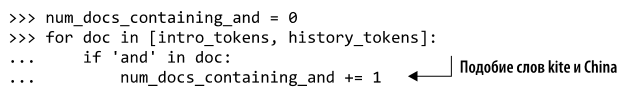

In [58]:
num_docs_containing_and=0
for doc in [intro_tokens, history_tokens]:
  if 'and' in doc:
    num_docs_containing_and+=1
    
num_docs_containing_and

2

Найдем TF China в обоих документах: 

In [59]:
intro_tf['china'] = intro_counts['china'] / intro_total
history_tf['china'] = history_counts['china'] / history_total

Вычислим IDF для всех трех слов. Хранить IDF мы будем в словарях для каждого документа, как мы это делали с TF: 

In [61]:
num_docs_containing_and = 0
num_docs_containing_kite = 0
num_docs_containing_china = 0
for doc in [intro_tokens, history_tokens]:
    if 'and' in doc:
        num_docs_containing_and += 1
    if 'kite' in doc:
        num_docs_containing_kite += 1
    if 'china' in doc:
        num_docs_containing_china += 1
print('and=%d ; kite=%d; china=%d' %(num_docs_containing_and,num_docs_containing_kite,num_docs_containing_china))

and=2 ; kite=2; china=1


In [62]:
num_docs = 2
intro_idf = {}
history_idf = {}
intro_idf['and'] = num_docs / num_docs_containing_and
history_idf['and'] = num_docs / num_docs_containing_and
intro_idf['kite'] = num_docs / num_docs_containing_kite
history_idf['kite'] = num_docs / num_docs_containing_kite
intro_idf['china'] = num_docs / num_docs_containing_china
history_idf['china'] = num_docs / num_docs_containing_china

А затем вычислим то же самое для документа с первыми абзацами статьи из «Википедии»: 

In [63]:
intro_tfidf = {}
intro_tfidf['and'] = intro_tf['and'] * intro_idf['and']
intro_tfidf['kite'] = intro_tf['kite'] * intro_idf['kite']
intro_tfidf['china'] = intro_tf['china'] * intro_idf['china']

И то же самое для документа с разделом History:

In [64]:
history_tfidf = {}
history_tfidf['and'] = history_tf['and'] * history_idf['and']
history_tfidf['kite'] = history_tf['kite'] * history_idf['kite']
history_tfidf['china'] = history_tf['china'] * history_idf['china']

## Возвращаемся к закону Ципфа

 Мы почти справились с заданием. Впрочем, допустим, что наш корпус состоит из 1 миллиона документов (например, у вас своя маленькая поисковая система) и ктото ищет слово cat. Предположим, что из 1 миллиона документов cat содержит ровно один документ. Чистый IDF этого слова равен:

1 000 000 / 1 = 1 000 000.

 Теперь представим, что из этого миллиона документов десять содержат слово dog. Тогда IDF этого слова будет: 
 
 1 000 000 / 10 = 100 000.

Как вы могли заметить, разница довольно большая. Наш друг Ципф сказал бы, что слишком большая. Закон Ципфа гласит, что при сравнении частотностей двух слов, таких как cat и dog, даже если они встречаются одинаковое количество раз, частотность более употребляемого слова будет экспоненциально выше, чем менее частого. Таким образом, закон Ципфа предполагает масштабирование всех частотностей слов (и частотностей документов) с помощью функции log(), обратной к функции exp(). Это гарантирует, что такие слова, как cat и dog, встречающиеся близкое число раз, не будут экспоненциально отличаться по частотности. Кроме того, такое распределение частотностей слов обеспечит более равномерное распределение показателей TF-IDF. Таким образом, IDF нужно переопределить так, чтобы он был равен логарифму исходной вероятности появления слова в одном из документов. Желательно также взять логарифм частотности терма.

Основание логарифма не имеет особого значения ввиду того, что мы хотим просто сделать распределение частотностей равномерным, а не масштабировать его до пределов определенного числового диапазона2. При использовании логарифма по основанию 10 получится: 

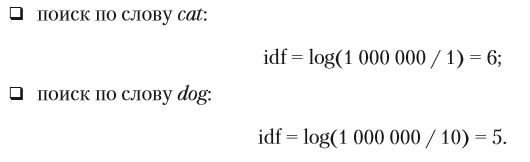

Теперь мы учитываем в результатах TF каждого из этих слов вес в соответствии с частотностью их в языке в целом.

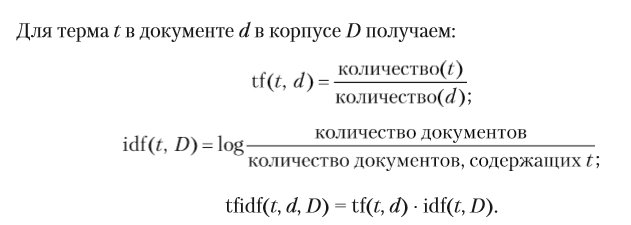

Таким образом, чем больше раз слово встречается в документе, тем выше будет значение TF (и, следовательно, TF-IDF). В то же время по мере увеличения количества документов, содержащих слово, его IDF (и, следовательно, TF-IDF) будет уменьшаться. Итак, теперь у вас есть число — то, с чем компьютер может работать. Но что оно означает? Оно связывает определенное слово или токен с конкретным документом в определенном корпусе, а затем задает числовое значение важности этого слова в данном документе с учетом его встречаемости во всем корпусе.

 Иногда все вычисления выполняются в логарифмическом пространстве, так что умножение становится сложением, а деление — вычитанием:

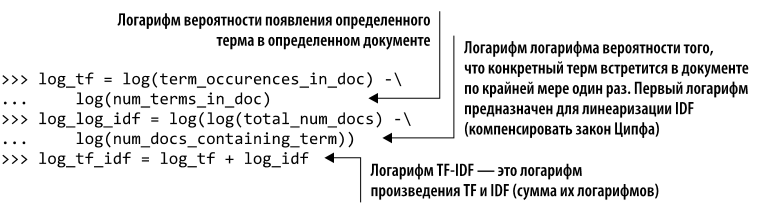

In [65]:
log_tf=log(term_occurences_in_doc)-log(num_terms_in_doc)
log_idf=log(log(total_num_docs)-log(num_docs_containing_term))
log_tf_idf=log_tf+log_idf

NameError: ignored

### Ранжирование по релевантности 

Как вы уже видели, сравнить два вектора и узнать степень их подобия не очень сложно. Однако с тех пор вы также узнали, что простой подсчет слов не так информативен, как использование их TF-IDF. Так что заменим в каждом векторе документа word_count каждого слова на его TF-IDF. Теперь наши векторы точнее отражают смысл (тему) документа, как показано в следующем примере о Гарри:

Полученное число, TF-IDF, — скромный фундамент нашей простой поисковой системы. И раз мы уже твердо шагнули из мира текста в мир чисел, пришло время заняться математикой. Вероятно, вам никогда не придется реализовывать вышеприведенные формулы для вычисления TF-IDF. Линейная алгебра не требуется для полного понимания инструментов, используемых при обработке естественного языка, но общее знакомство с этой математикой сделает ее применение интуитивно понятнее. 

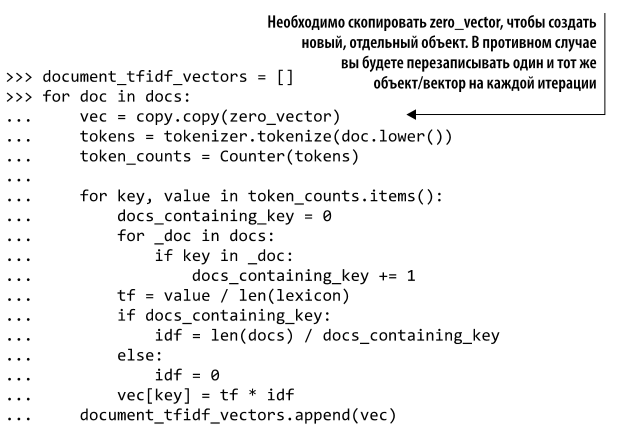

In [69]:
document_tfidf_vectors=[]
for doc in docs:
  vec=copy.copy(zero_vector)
  tokens=tokenizer.tokenize(doc.lower())
  token_counts=Counter(tokens)

  for key, value in token_counts.items():
    docs_containing_key=0
    for _doc in docs:
      if key in _doc:
        docs_containing_key+=1
    tf=value/len(lexicon)
    if docs_containing_key:
      idf=len(docs)/docs_containing_key
    else:
      idf=0
    vec[key]=tf*idf
  document_tfidf_vectors.append(vec)

In [70]:
document_tfidf_vectors

[OrderedDict([(',', 0.16666666666666666),
              ('.', 0.05555555555555555),
              ('and', 0.08333333333333333),
              ('as', 0),
              ('faster', 0.25),
              ('get', 0.16666666666666666),
              ('got', 0.16666666666666666),
              ('hairy', 0),
              ('harry', 0.0),
              ('home', 0.16666666666666666),
              ('is', 0),
              ('jill', 0),
              ('not', 0),
              ('store', 0.16666666666666666),
              ('than', 0),
              ('the', 0.5),
              ('to', 0.16666666666666666),
              ('would', 0.16666666666666666)]),
 OrderedDict([(',', 0),
              ('.', 0.05555555555555555),
              ('and', 0.08333333333333333),
              ('as', 0),
              ('faster', 0.08333333333333333),
              ('get', 0),
              ('got', 0),
              ('hairy', 0.08333333333333333),
              ('harry', 0.0),
              ('home', 0),
              ('i

При таких настройках у нас есть K-мерное векторное представление каждого документа в корпусе. А теперь приступим к охоте! Или к поиску в нашем случае. Два вектора в векторном пространстве называются подобными, если одинаковы углы с его базисными векторами. Если представить, что каждый из этих векторов возникает в начале координат при тех же длинах и направлениях, то векторы, направленные под одинаковым углом, подобны, даже если их длины различны. Два вектора считаются подобными, если значение их косинусного коэффициента велико, поэтому для поиска подобных векторов поблизости можно максимизировать:

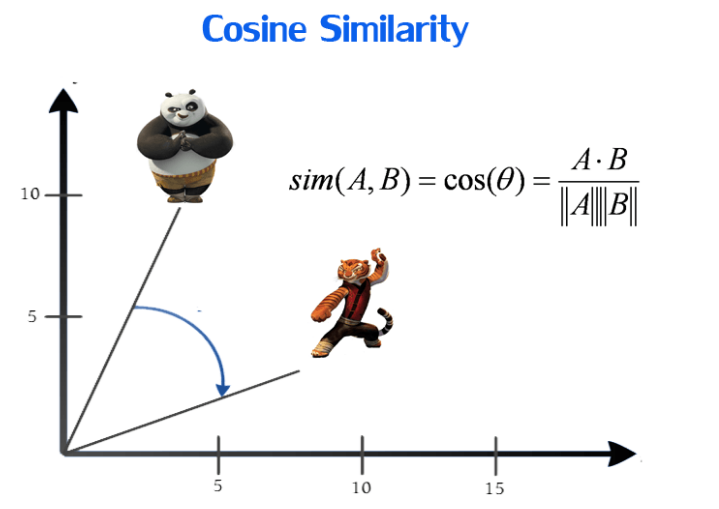

#### https://colab.research.google.com/github/goodboychan/goodboychan.github.io/blob/main/_notebooks/2020-07-17-04-TF-IDF-and-similarity-scores.ipynb

Теперь у нас есть все, что нужно для простого поиска на основе TF-IDF. Поисковый запрос можно рассматривать как документ, для которого существует векторное представление на основе TF-IDF. Последний шаг — найти документы, векторы которых имеют наибольшие косинусные коэффициенты с запросом, и вернуть их в качестве результатов поиска. 

Для запроса How long does it take to get to the store? и трех наших документов о Гарри получается:

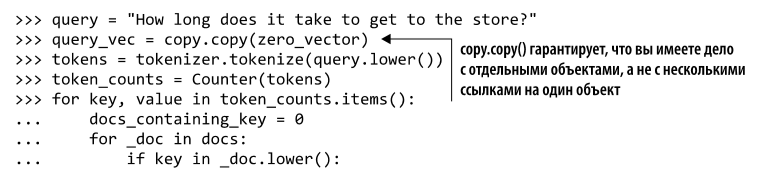

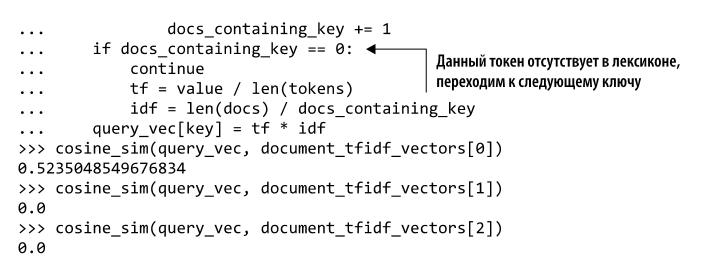

Можно с уверенностью утверждать, что документ 0 наиболее релевантен запросу. Аналогичным образом можно использовать релевантные документы в любом корпусе. Неважно в каком — в статьях из «Википедии», книгах из проекта «Гутенберг» или твитах из Twitter. Google, берегись! 


Поисковая система Google может нас не бояться. Для каждого запроса нам приходится выполнять поиск по индексу среди векторов TF-IDF. Это алгоритм порядка O(N). Большинство поисковых систем отвечают за фиксированный промежуток времени (O(1)), потому что используют обратный индекс (ru.wikipedia.org/wiki/ Инвертированный_индекс). Мы не собираемся реализовывать здесь индекс, пригодный для поиска соответствий за фиксированный промежуток времени, но, если вам интересно, взгляните на современную реализацию на языке Python из пакета Whoosh (pypi.python.org/pypi/Whoosh) и ее исходный код1. Вместо того чтобы демонстрировать создание подобной традиционной поисковой системы на основе ключевых слов, в главе 4 мы расскажем про новейшие подходы семантического индексирования, захватывающие смысл текста.


## ПРИМЕЧАНИЕ 

> В предыдущем коде мы отбросили отсутствующие в лексиконе ключи, чтобы избежать ошибки деления на ноль. Куда лучшим подходом будет прибавление 1 к знаменателю при каждом вычислении IDF, что гарантирует отсутствие нулевых знаменателей. На деле этот подход, называемый аддитивным сглаживанием (сглаживанием Лапласа) (en.wikipedia.org/wiki/Additive_smoothing), обычно улучшает результаты поиска по ключевым словам TF-IDF.


Поиск по ключевым словам — это только один из инструментов нашего NLPконвейера. Мы собираемся создать чат-бот, а некоторые чат-боты используют в качестве единственного алгоритма генерации ответов исключительно поисковую систему. Нам нужно сделать еще один шаг, чтобы превратить наш простой поисковый индекс (TF-IDF) в чат-бот. Нам также необходимо хранить тренировочные данные в виде пар вопросов (высказываний) и соответствующих ответов. При этом можно применять TF-IDF для поиска вопроса (высказывания), наиболее похожего на вводимый пользователем текст. Вместо того чтобы возвращать наиболее похожее высказывание из базы данных, мы будем возвращать соответствующий этому высказыванию ответ. Как и любая сложная задача из сферы компьютерных наук, наша может быть решена с помощью добавления еще одного слоя косвенности. И все, чат-бот готов! 

## Инструменты 

Выше было приведено много кода для давно уже автоматизированных операций. То же самое можно сделать намного проще с помощью пакета scikit-learn1. Если вы еще не настроили свою среду согласно информации из приложения A таким образом, чтобы она включала этот пакет, вот один из способов его инсталляции:

In [71]:
!pip install scipy 
!pip install sklear

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement sklear (from versions: none)
ERROR: No matching distribution found for sklear


Так вы можете использовать sklearn для построения матрицы TF-IDF. Класс для TF-IDF библиотеки sklearn — это модель с методами .fit() и .transform(), которые соответствуют API sklearn для всех моделей машинного обучения:

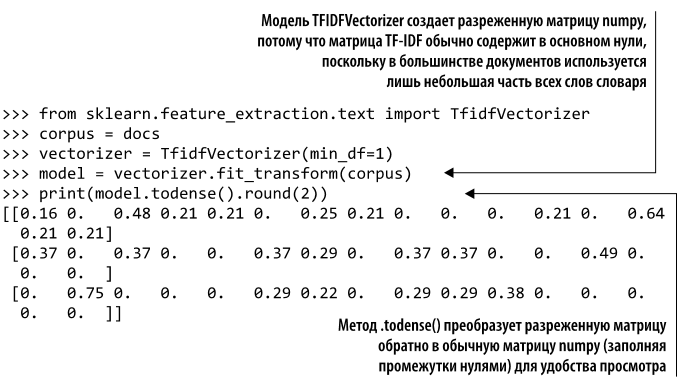

С помощью библиотеки scikit-learn, написав всего четыре строки кода, мы смогли создать матрицу для трех документов и IDF для всех термов лексикона. Полученная матрица (которая в Python фактически представляет собой список списков) отражает наши три документа (три строки матрицы). TF-IDF каждого терма, токена или слова лексикона составляют столбцы матрицы (или опять же индексы строк). Их всего 16, так как они по-разному токенизируются, а знаки пунктуации отбрасываются — в нашем случае запятая и точка. При работе с большими текстами эта или другая предварительно оптимизированная модель TF-IDF поможет сэкономить массу времени.

## Альтернативы 

Матрицы TF-IDF (матрицы «терм — документ») были основой поиска информации на протяжении десятилетий. В результате исследователи и корпорации потратили много времени, пытаясь оптимизировать связанную с IDF часть, чтобы повысить релевантность результатов поиска. В табл. 3.1 перечислены некоторые способы нормализации и сглаживания весовых коэффициентов частотностей термов.

![image.png]()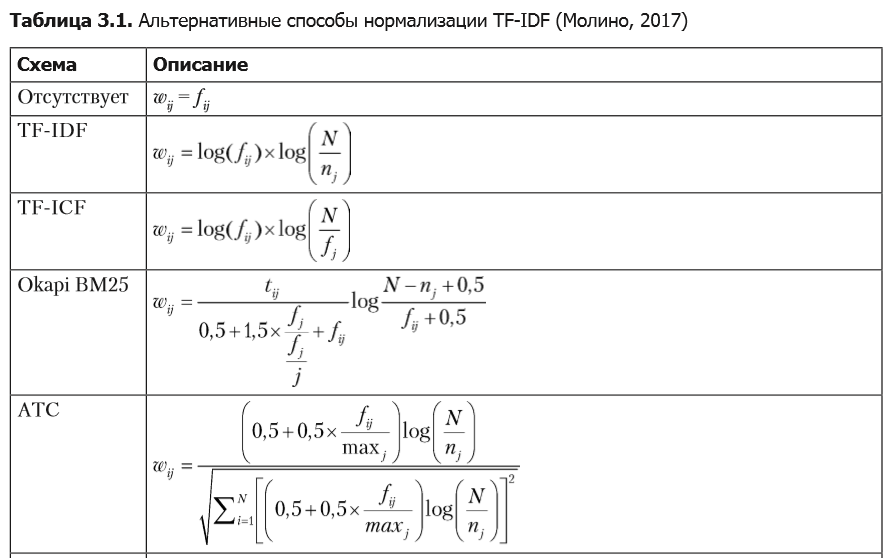

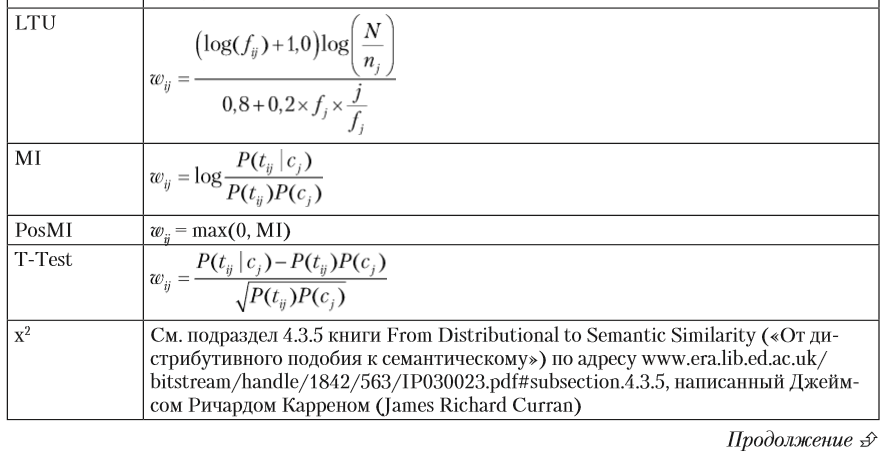

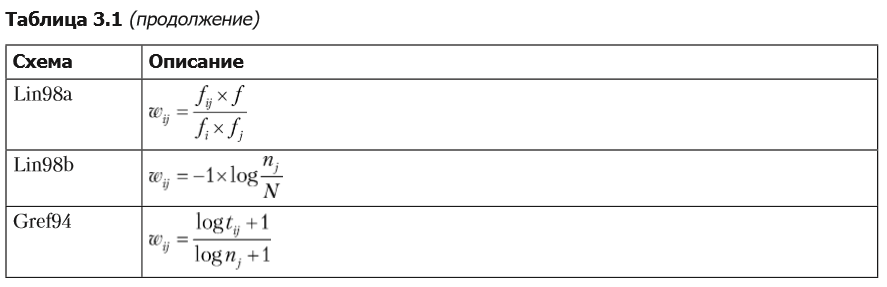

Поисковые системы (информационно-поисковые системы) сопоставляют ключевые слова (термы) из запросов и документов корпуса. Если вы решили создать поисковую систему и хотите выдавать по возможности искомые пользователями документы, рекомендуем потратить некоторое время на изучение альтернатив, описанных Пьеро Молино (Piero Molino) в табл. 3.1. 

Одним из альтернативных способов использования непосредственно косинусного расстояния TF-IDF для ранжирования результатов запроса вариантов является Okapi BM25 или его самый последний вариант BM25F. 

## Okapi BM25 

Умные люди из Лондонского университета Сити придумали лучший способ ранжирования результатов поиска. Вместо простого вычисления косинусного подобия TF-IDF они его нормализовали и сгладили, а также проигнорировали повторяющиеся термы в документе запроса, фактически обрезая частотности термов вектора запроса в 1. Скалярное произведение косинусного подобия нормализуется не векторной нормой TF-IDF (количеством слов в документе и запросе), а с помощью нелинейной функции от длины самого документа: 

### q_idf * dot(q_tf, d_tf[i]) * 1.5 /(dot(q_tf, d_tf[i]) + .25 + .75 * d_num_words[i] / d_num_words.mean())) 

Вы можете оптимизировать свой конвейер, выбрав схему взвешивания, выдающую вашим пользователям наиболее релевантные результаты. Если же ваш корпус не слишком велик, то можете отправиться вместе с нами далее и узнать о более удобных и точных представлениях смысла слов и документов. В следующих главах мы покажем, как реализовать семантическую поисковую систему, находящую документы, близкие по смыслу к словам из запроса, а не просто документы, содержащие в точности те же слова, что и в запросе. Семантический поиск гораздо лучше всего, чего можно достичь с помощью методов использования весов TF-IDF, стемминга и лемматизации. Единственная причина, по которой Google, Bing и другие поисковые системы не используют подход семантического поиска, заключается в слишком больших размерах их корпусов. Семантические векторы слов и тем не масштабируются до миллиардов документов, хотя применять их для корпусов в миллионы документов можно.

## Что дальше? 

Теперь, когда мы научились преобразовывать текст на естественном языке в числа, начнем производить над этими числами различные операции и вычисления. Числа у нас уже есть, и в следующей главе мы займемся их уточнением в попытке лучше отразить смысл (тему) текста на естественном языке, а не только отдельных слов. 

## Резюме

* «Под капотом» любой поисковой системы интернет-масштаба со временем отклика порядка миллисекунд находится матрица «терм — документ» (TF-IDF). 
*  Частотности термов необходимо умножить на веса в виде обратных частотностей документов, чтобы гарантировать достаточный вес важнейших, несущих наибольший смысл слов.
*  Закон Ципфа позволяет предсказать частотность чего угодно, включая слова, символы и людей. 
* Строки TF-IDF матрицы «терм— документ» можно использовать в качестве векторного представления смыслов отдельных слов для создания векторной модели семантики слов. 
*  Евклидово расстояние и подобие между парами многомерных векторов не дает адекватного отображения их сходства в большинстве приложений NLP. 
* Для эффективного вычисления косинусного расстояния, величины «перекрытия» векторов, достаточно просто перемножить элементы нормализованных векторов и просуммировать полученные произведения. 
* Косинусное расстояние — оптимальный показатель подобия для большинства векторных представлений текстов на естественном языке.


## Домашняя работа

Из книги **"Ганегедара	Т. Г. Обработка естественного языка с TensorFlow / пер. с анг. В. С. Яценкова. – М.: ДМК Пресс, 2020. – 382 с.: ил."** прочитать "Глава 3. Word2vec и вектор слова в пространстве смыслов" 

### https://classroom.google.com/c/NTQ0NzcyNzAxMTIz
